In [30]:
from argparse import Namespace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import graphviz
from sklearn import datasets 
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

train acc: 0.68, test acc: 0.73


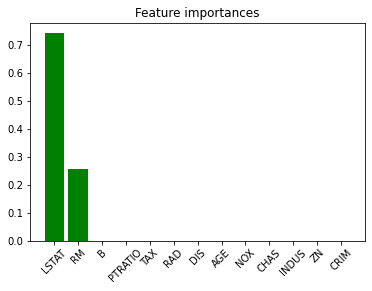

LSTAT - 0.743
RM - 0.257
B - 0.000
PTRATIO - 0.000
TAX - 0.000
RAD - 0.000
DIS - 0.000
AGE - 0.000
NOX - 0.000
CHAS - 0.000
INDUS - 0.000
ZN - 0.000
CRIM - 0.000


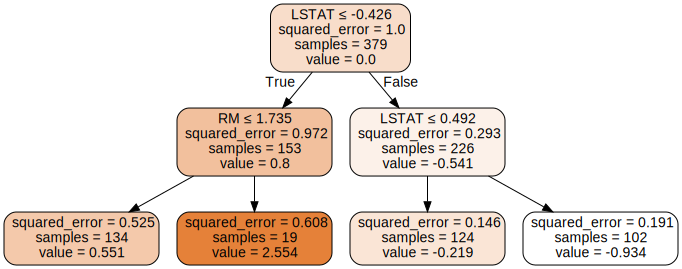

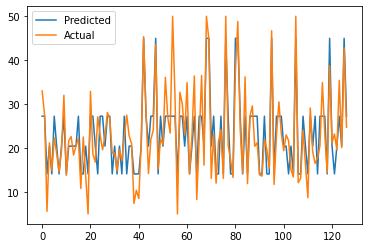

In [31]:
args = Namespace(
    seed=1234,
    train_size=0.75,
    test_size=0.25,
    max_depth=3,  # distance between leaf and root
    max_leaf_nodes=4,
    n_estimators=100,
    lr=0.05,
    min_child_weight=0.1, # XGBoost only
    gamma=0.3 # XGBoost only
)

dataset = datasets.load_boston() # dataset for regression
warnings.filterwarnings("ignore")
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, train_size=args.train_size, test_size=args.test_size, random_state=args.seed)

X_scaler = StandardScaler().fit(X_train) # standardize the train and test sets
y_scaler = StandardScaler().fit(y_train.reshape(-1,1)) 
standardized_X_train = X_scaler.transform(X_train)
standardized_y_train = y_scaler.transform(y_train.reshape(-1,1)).ravel()
standardized_X_test = X_scaler.transform(X_test)
standardized_y_test = y_scaler.transform(y_test.reshape(-1,1)).ravel()

single_tree = DecisionTreeRegressor(random_state=args.seed,
                                    max_depth=args.max_depth,
                                    max_leaf_nodes=args.max_leaf_nodes)
single_tree.fit(standardized_X_train, standardized_y_train)
pred_train = single_tree.predict(standardized_X_train) 
pred_test = single_tree.predict(standardized_X_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(single_tree.score(standardized_X_train, standardized_y_train), single_tree.score(standardized_X_test, standardized_y_test)))

features = dataset.feature_names
importances = single_tree.feature_importances_
indices = np.argsort(importances)[::-1]  # rank features by importance from high to low
num_features = len(importances)

plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()
for i in indices:
    print("{0} - {1:.3f}".format(features[i], importances[i]))
    
reverse_pred_test = y_scaler.inverse_transform(pred_test.reshape(-1,1)).ravel()
plt.figure()
plt.plot(reverse_pred_test, label='Predicted')
plt.plot(y_test, label='Actual')
plt.legend()
    
single_tree_graph = export_graphviz(single_tree, out_file=None,
                           feature_names=dataset.feature_names,
                           filled=True, rounded=True,
                           special_characters=True)
graphviz.Source(single_tree_graph)

forest train acc: 0.79, forest test acc: 0.80


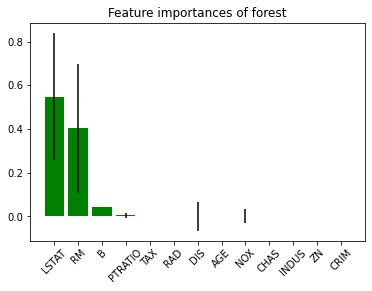

LSTAT - 0.548
RM - 0.403
DIS - 0.042
NOX - 0.005
PTRATIO - 0.001
B - 0.000
TAX - 0.000
RAD - 0.000
AGE - 0.000
CHAS - 0.000
INDUS - 0.000
ZN - 0.000
CRIM - 0.000


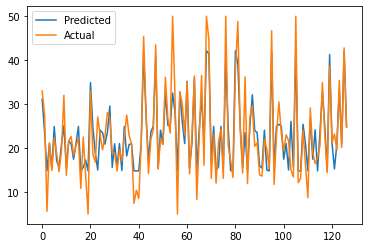

In [32]:
# random forests
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
    n_estimators=args.n_estimators, 
    max_depth=args.max_depth, 
    max_leaf_nodes=args.max_leaf_nodes)
forest.fit(standardized_X_train, standardized_y_train)

predict_forest_train = forest.predict(standardized_X_train)
predict_forest_test = forest.predict(standardized_X_test)
print("forest train acc: {0:.2f}, forest test acc: {1:.2f}".format(forest.score(standardized_X_train, standardized_y_train), forest.score(standardized_X_test, standardized_y_test)))

forest_importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_indices = np.argsort(forest_importances)[::-1]
forest_num_features = len(forest_importances)

plt.figure()
plt.title("Feature importances of forest")
plt.bar(range(forest_num_features), forest_importances[forest_indices], yerr=std[indices],
        color="g", align="center")
plt.xticks(range(forest_num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, forest_num_features])
plt.show()

for i in forest_indices:
    print("{0} - {1:.3f}".format(features[i], forest_importances[i]))

rf_reverse_pred_test = y_scaler.inverse_transform(predict_forest_test.reshape(-1,1)).ravel()
plt.figure()
plt.plot(rf_reverse_pred_test, label='Predicted')
plt.plot(y_test, label='Actual')
plt.legend()

Ada train acc: 0.90, Ada test acc: 0.87


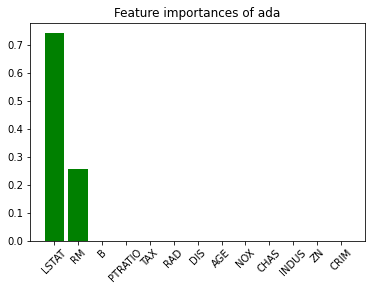

LSTAT - 0.542
RM - 0.304
DIS - 0.084
PTRATIO - 0.026
NOX - 0.012
CRIM - 0.010
TAX - 0.007
B - 0.005
AGE - 0.005
INDUS - 0.003
RAD - 0.002
CHAS - 0.000
ZN - 0.000


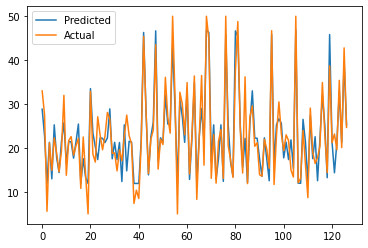

In [33]:
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(n_estimators=args.n_estimators, learning_rate=args.lr)
ada.fit(standardized_X_train, standardized_y_train)

predict_ada_train = ada.predict(standardized_X_train)
predict_ada_test = ada.predict(standardized_X_test)
print("Ada train acc: {0:.2f}, Ada test acc: {1:.2f}".format(ada.score(standardized_X_train, standardized_y_train), ada.score(standardized_X_test, standardized_y_test)))
#precision, recall, F1, _ = precision_recall_fscore_support(y_test, predict_GBDT_test, average="binary")
#print("GBDT precision: http://localhost:8888/notebooks/Jupyter%20notebook/Decision%20tree_Random%20forest_GBDT_Adaboost.ipynb#{0:.2f}. GBDT recall: {1:.2f}, forest F1: {2:.2f}".format(precision, recall, F1))

ada_importances = ada.feature_importances_
ada_indices = np.argsort(ada_importances)[::-1]
ada_num_features = len(ada_importances)

plt.figure()
plt.title("Feature importances of ada")
plt.bar(range(ada_num_features), importances[indices], color="g", align="center")
plt.xticks(range(ada_num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, ada_num_features])
plt.show()

for i in ada_indices:
    print("{0} - {1:.3f}".format(features[i], ada_importances[i]))
    

ada_reverse_pred_test = y_scaler.inverse_transform(predict_ada_test.reshape(-1,1)).ravel()
plt.figure()
plt.plot(ada_reverse_pred_test, label='Predicted')
plt.plot(y_test, label='Actual')
plt.legend()

      Iter       Train Loss   Remaining Time 
         1           0.9332            0.51s
         2           0.8727            0.33s
         3           0.8170            0.27s
         4           0.7668            0.24s
         5           0.7198            0.21s
         6           0.6767            0.19s
         7           0.6370            0.18s
         8           0.6006            0.16s
         9           0.5670            0.16s
        10           0.5357            0.15s
        20           0.3217            0.13s
        30           0.2139            0.10s
        40           0.1565            0.08s
        50           0.1236            0.06s
        60           0.1049            0.05s
        70           0.0931            0.04s
        80           0.0844            0.02s
        90           0.0778            0.01s
       100           0.0725            0.00s
GBDT train acc: 0.93, GBDT test acc: 0.88


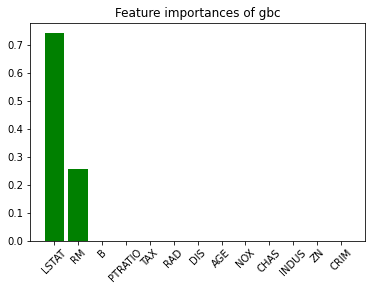

LSTAT - 0.483
RM - 0.338
DIS - 0.078
PTRATIO - 0.038
NOX - 0.034
CRIM - 0.014
TAX - 0.009
B - 0.004
RAD - 0.001
AGE - 0.001
CHAS - 0.000
INDUS - 0.000
ZN - 0.000


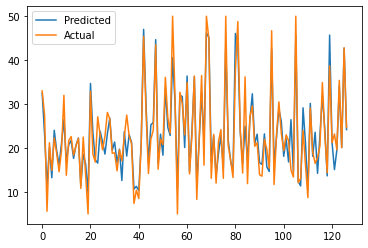

In [34]:
# GBDT
from sklearn.ensemble import GradientBoostingRegressor

gbc = GradientBoostingRegressor(learning_rate=args.lr,
                                 n_estimators=args.n_estimators,
                                 max_depth=args.max_depth,
                                 max_leaf_nodes=args.max_leaf_nodes,
                                 verbose=1
                                 )
gbc.fit(standardized_X_train, standardized_y_train)
predict_GBDT_train = gbc.predict(standardized_X_train)
predict_GBDT_test = gbc.predict(standardized_X_test)
print("GBDT train acc: {0:.2f}, GBDT test acc: {1:.2f}".format(gbc.score(standardized_X_train, standardized_y_train), gbc.score(standardized_X_test, standardized_y_test)))
#precision, recall, F1, _ = precision_recall_fscore_support(y_test, predict_GBDT_test, average="binary")
#print("GBDT precision: {0:.2f}. GBDT recall: {1:.2f}, forest F1: {2:.2f}".format(precision, recall, F1))

gbc_importances = gbc.feature_importances_
gbc_indices = np.argsort(gbc_importances)[::-1]
gbc_num_features = len(gbc_importances)

plt.figure()
plt.title("Feature importances of gbc")
plt.bar(range(gbc_num_features), importances[indices], color="g", align="center")
plt.xticks(range(gbc_num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, gbc_num_features])
plt.show()

for i in gbc_indices:
    print("{0} - {1:.3f}".format(features[i], gbc_importances[i]))
    
    
GBDT_reverse_pred_test = y_scaler.inverse_transform(predict_GBDT_test.reshape(-1,1)).ravel()
plt.figure()
plt.plot(GBDT_reverse_pred_test, label='Predicted')
plt.plot(y_test, label='Actual')
plt.legend()

[16:32:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBoost train acc: 0.95, XGBoost test acc: 0.90


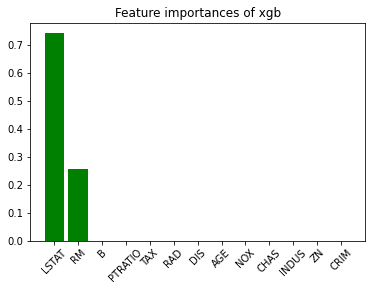

LSTAT - 0.465
RM - 0.226
DIS - 0.065
PTRATIO - 0.053
NOX - 0.043
CRIM - 0.026
TAX - 0.021
B - 0.025
RAD - 0.010
AGE - 0.020
CHAS - 0.013
INDUS - 0.031
ZN - 0.000


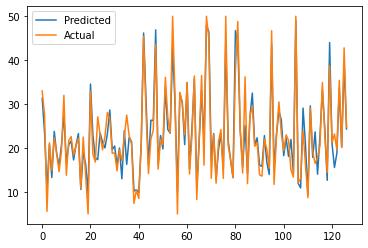

In [35]:
# XGBoost
from xgboost import XGBRegressor

xgb = XGBRegressor(
    max_depth=args.max_depth,
    learning_rate=args.lr, 
    n_estimators=args.n_estimators, 
    verbosity=1, 
    objective='reg:squarederror', 
    max_leaf_nodes=args.max_leaf_nodes,
    min_child_weight=args.min_child_weight,
    gamma=args.gamma,
    random_state=args.seed
)
xgb.fit(standardized_X_train, standardized_y_train)
predict_xgb_train = xgb.predict(standardized_X_train)
predict_xgb_test = xgb.predict(standardized_X_test)
print("XGBoost train acc: {0:.2f}, XGBoost test acc: {1:.2f}".format(xgb.score(standardized_X_train, standardized_y_train), xgb.score(standardized_X_test, standardized_y_test)))
#precision, recall, F1, _ = precision_recall_fscore_support(y_test, predict_GBDT_test, average="binary")
#print("GBDT precision: {0:.2f}. GBDT recall: {1:.2f}, forest F1: {2:.2f}".format(precision, recall, F1))

xgb_importances = xgb.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]
xgb_num_features = len(xgb_importances)

plt.figure()
plt.title("Feature importances of xgb")
plt.bar(range(xgb_num_features), importances[indices], color="g", align="center")
plt.xticks(range(xgb_num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, xgb_num_features])
plt.show()

for i in gbc_indices:
    print("{0} - {1:.3f}".format(features[i], xgb_importances[i]))
    
    
xgb_reverse_pred_test = y_scaler.inverse_transform(predict_xgb_test.reshape(-1,1)).ravel()
plt.figure()
plt.plot(xgb_reverse_pred_test, label='Predicted')
plt.plot(y_test, label='Actual')
plt.legend()

In [36]:
# lightGBM


In [37]:
print ("Single tree train acc: {0:.2f}, test acc: {1:.2f}".format(single_tree.score(standardized_X_train, standardized_y_train), single_tree.score(standardized_X_test, standardized_y_test)))
print("forest train acc: {0:.2f}, forest test acc: {1:.2f}".format(forest.score(standardized_X_train, standardized_y_train), forest.score(standardized_X_test, standardized_y_test)))
print("Ada train acc: {0:.2f}, Ada test acc: {1:.2f}".format(ada.score(standardized_X_train, standardized_y_train), ada.score(standardized_X_test, standardized_y_test)))
print("GBDT train acc: {0:.2f}, GBDT test acc: {1:.2f}".format(gbc.score(standardized_X_train, standardized_y_train), gbc.score(standardized_X_test, standardized_y_test)))
print("XGBoost train acc: {0:.2f}, XGBoost test acc: {1:.2f}".format(xgb.score(standardized_X_train, standardized_y_train), xgb.score(standardized_X_test, standardized_y_test)))


Single tree train acc: 0.68, test acc: 0.73
forest train acc: 0.79, forest test acc: 0.80
Ada train acc: 0.90, Ada test acc: 0.87
GBDT train acc: 0.93, GBDT test acc: 0.88
XGBoost train acc: 0.95, XGBoost test acc: 0.90
